<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

0    3270
2    2542
5    2190
4    1773
6    1609
1    1501
3     475
Name: state, dtype: int64

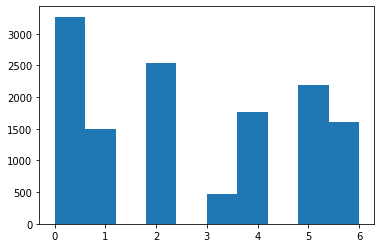

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 12, 29),
 datetime.date(2022, 12, 17),
 datetime.date(2012, 12, 19),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 12, 29), datetime.date(2022, 12, 17))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/max(n - 1, 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_26806/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_26806/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_26806/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_26806/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_26806/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_26806/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000295,0.998080,1.000475,1.026496,1.002054,1.002521,1.000287,1.002279
AA,1.000259,0.997155,1.000971,1.001568,1.000152,1.002043,1.000501,1.001355
AAIC,0.999495,0.997528,1.000261,1.020615,1.001556,1.002131,0.999312,1.000201
AAL,0.999919,0.995581,1.001663,1.016345,1.003315,1.000753,1.002294,1.001818
AAME,0.999972,0.997477,1.001310,1.001094,1.000849,1.001089,1.000519,1.000339


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000546,0.999611,0.995609,1.015210,1.010501,1.003647,0.997711,0.999146
ZTR,1.000193,0.999196,1.000377,1.001210,1.000998,1.000635,1.000659,1.000708
ZUMZ,1.000110,0.997149,1.000991,0.980082,1.003189,1.000766,1.003198,1.000994
ZWS,1.000032,0.996938,0.999386,1.018768,0.998978,1.001752,1.000801,1.001925
ZYXI,1.000494,0.999394,1.001406,0.985492,1.000701,1.000374,0.995063,1.004226


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

0

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar)
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.3*df[f'dar_{CURRENT_STATE}']
        + 0.5*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
PRTA,inf,0.994881,1.003406,1.023761,1.005673,inf,0.998763,1.001824,inf
ELC,1.001268,1.003858,0.998346,0.983175,1.001131,1.001577,1.000098,1.000960,1.002789
FSI,1.001285,1.002488,0.999758,1.000568,1.000591,1.000499,1.000301,1.001941,1.001975
MICS,0.999233,1.001866,0.999871,1.016391,0.993291,0.997719,0.996709,0.997594,1.001140
GCBC,1.000710,1.001081,1.000618,0.998567,1.000057,1.000505,1.000484,1.000458,1.000960


In [32]:
df.mean(), df.median()

(dar              inf
 dar_0       0.998186
 dar_1       1.000525
 dar_2       1.007965
 dar_3       1.001315
 dar_4            inf
 dar_5       1.000613
 dar_6       1.001132
 weighted         inf
 dtype: float64,
 dar         1.000258
 dar_0       0.998380
 dar_1       1.000581
 dar_2       1.003993
 dar_3       1.001258
 dar_4       1.001267
 dar_5       1.000789
 dar_6       1.001093
 weighted    0.998987
 dtype: float64)

In [70]:
always_exclude = ['NXN', 'NXP']
exclude = {
    0: ['CTSH', 'DG', 'ELC', 'POOL', 'PRTA', 'UTMD', 'WTRG'],
    1: ['DTST', 'FSI'],
    7: ['ELC']}

In [71]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [72]:
print(sorted(best_weighted))
#sorted(best_weighted)

['ABST', 'AGI', 'APT', 'CEF', 'CFFN', 'CZFS', 'DGX', 'EBMT', 'ESOA', 'FCN', 'FNV', 'FSI', 'GCBC', 'HMY', 'IEI', 'LFMD', 'MICS', 'MTA', 'NEN', 'YORW']


In [73]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
FSI,1.001285,1.002488,0.999758,1.000568,1.000591,1.000499,1.000301,1.001941,1.001975
MICS,0.999233,1.001866,0.999871,1.016391,0.993291,0.997719,0.996709,0.997594,1.001140
GCBC,1.000710,1.001081,1.000618,0.998567,1.000057,1.000505,1.000484,1.000458,1.000960
ESOA,0.999879,1.001433,0.999650,1.013056,1.001201,0.997907,0.995996,0.999948,1.000944
MTA,1.000488,1.001056,0.999988,0.995722,0.998145,1.000509,0.999114,1.001495,1.000836
LFMD,1.000404,1.000484,1.003263,0.927530,1.004876,0.997908,0.993958,1.000061,1.000746
ABST,1.000458,1.000655,1.000356,1.000044,1.001751,0.999966,0.997350,1.001054,1.000586
FNV,1.000624,1.000466,1.001119,1.012952,0.999928,1.000927,1.000781,1.000122,1.000562
NEN,1.000680,1.000461,1.000093,1.001425,1.001204,1.000768,1.001019,1.001034,1.000468
APT,1.000269,1.000676,0.999343,1.040593,0.995054,1.000480,1.000379,1.001455,1.000462


In [74]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [75]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABST,AGI,APT,CEF,CFFN,CZFS,DGX,EBMT,ESOA,FCN,FNV,FSI,GCBC,HMY,IEI,LFMD,MICS,MTA,NEN,YORW
Date,,,,,,,,,,,,,,,,,,,,
2022-12-12,9.57,9.89,4.01,17.510000,8.22,73.262375,149.000000,17.110001,2.76,161.880005,141.850006,3.41,72.059998,3.37,115.669487,2.47,4.91,5.27,72.180527,46.200001
2022-12-13,9.80,10.01,4.04,17.969999,8.29,73.858566,149.750000,16.900000,2.80,158.350006,144.119995,3.56,72.949997,3.51,116.348366,2.46,4.75,5.37,72.300003,46.470001
2022-12-14,9.96,9.92,4.07,17.860001,8.02,75.200005,151.110001,16.879999,2.75,159.630005,143.809998,3.55,72.150002,3.51,116.568008,2.40,4.61,5.09,72.129997,46.020000
2022-12-15,10.05,9.49,4.09,17.379999,7.92,75.900002,149.220001,16.309999,2.74,157.419998,137.779999,3.28,67.800003,3.23,116.589996,2.30,4.95,5.12,71.000000,45.000000
2022-12-16,9.97,9.64,4.09,17.459999,7.94,76.330002,149.240005,16.730000,2.84,154.529999,132.500000,3.28,68.699997,3.21,116.570000,2.27,4.77,5.33,71.000000,45.250000


In [76]:
data = pd.concat([data, states], axis=1)

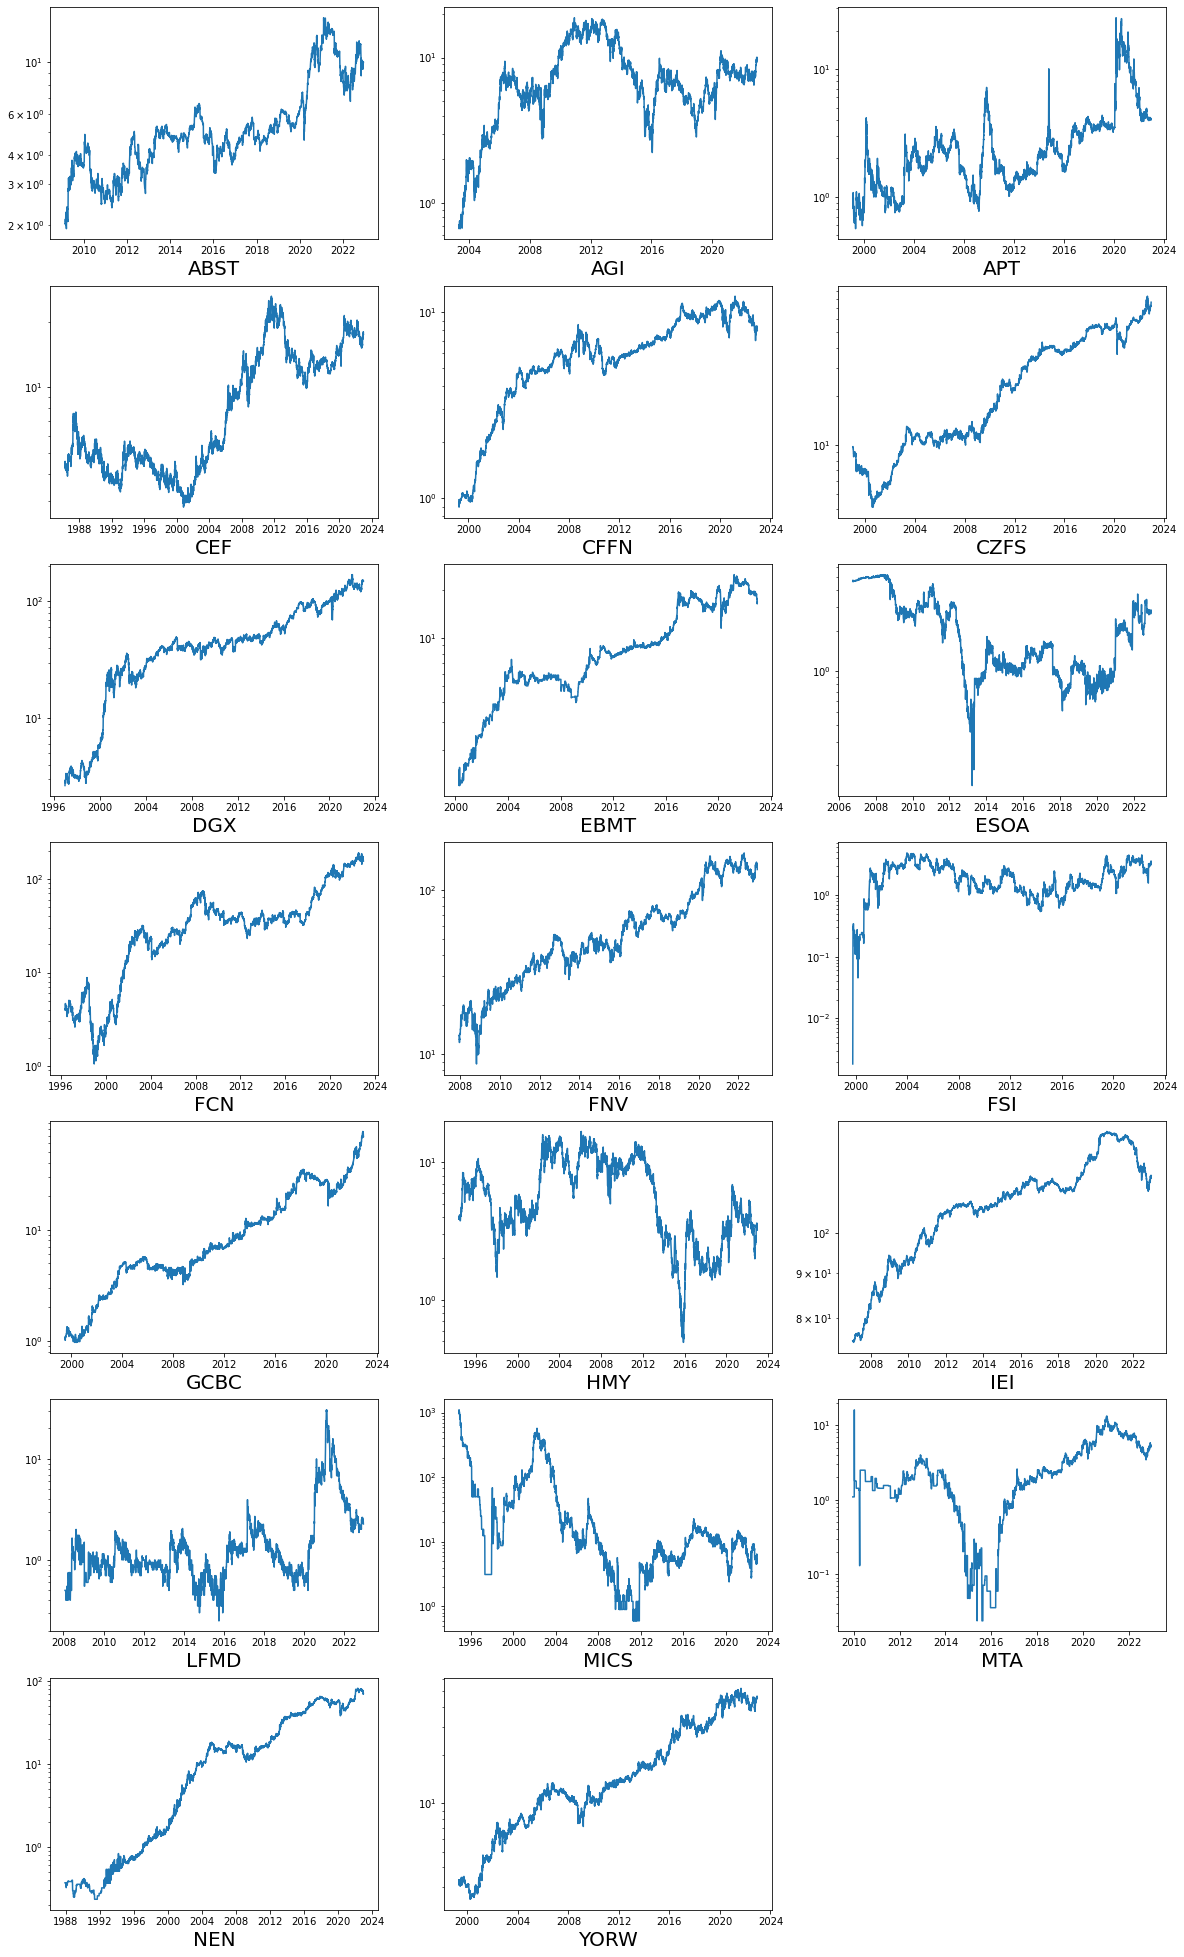

In [77]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

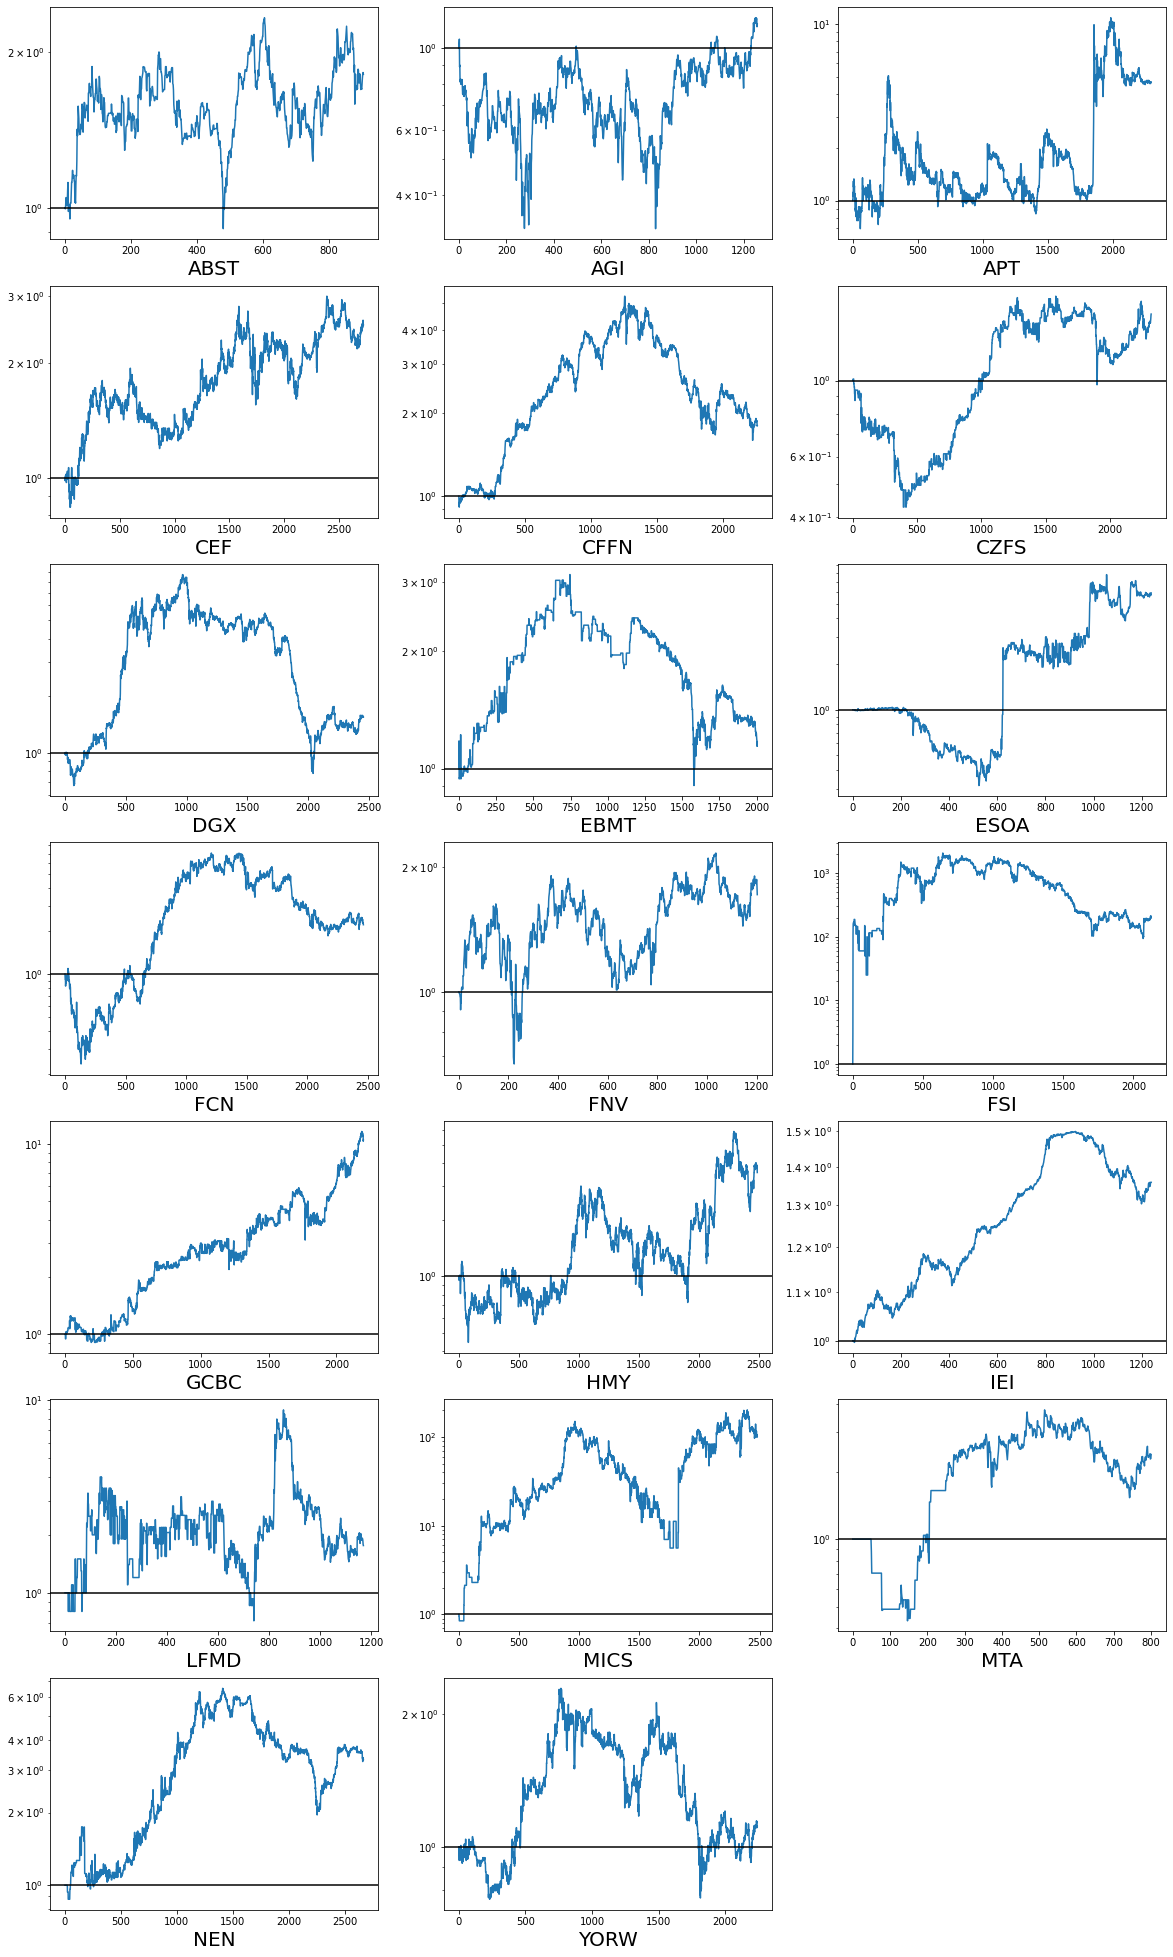

In [78]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);